# Project Overview

This project intends to show how to implent a Machine Learning Data Monitoring. This concept is particular important when we are dealing with Machine Learning Operations. The libary we are going to use is `Evidently`.

In Evidently we have two main types of information: 

1. **Reports**: useful when we want to visualize the information, for monitoring or presentation purposes. Reports can be aggregated in a `dashboard`, in order to show data behavior across time; 
2. **Tests**: useful for integrating with pipelines, as "validation" steps or to trigger to retraining in CI/CD

Evidently support both `self-hosting` and `cloud`, in this project I am going to use `self-hosting`.

Evidently supports `tabular data` and `text data` also, in this project we are going to use `tabular data`.

Evidently supports `regression`, `binary` and `multiclass-classification`. For the last two we can choose the evaluate the absolute classifications or the probabilistic.

For privacy purposes we are going to use a public domain dataset.




# Model Monitoring Overview

Machine learning model monitoring is the systematic process of tracking, analyzing, and evaluating ML models in production environments. This guide provides a comprehensive overview of model monitoring fundamentals and best practices.

## What is Model Monitoring?

Model monitoring is essential for maintaining ML model performance and reliability after deployment. It involves tracking various metrics and indicators to ensure models remain accurate and effective over time. Unlike traditional software monitoring, ML models require specialized attention due to their dependency on data patterns and statistical relationships.

## Key Challenges in Production

**Several challenges make model monitoring critical:**

1. Gradual Concept Drift: The relationship between variables can change slowly over time, leading to degraded model performance. For example, customer preferences in recommendation systems evolve gradually.

2. Sudden Concept Drift: Unexpected external events can cause abrupt changes in model environments. The COVID-19 pandemic is a prime example, causing rapid shifts in many prediction models.

3. Data Distribution Drift: Statistical properties of input data may change, such as shifts in customer demographics or behavior patterns.

4. Data Quality Issues: Problems with input data accuracy, completeness, or reliability can compromise model performance.

5. Pipeline Bugs: Technical issues in data processing can lead to corrupted or delayed data.

6. Adversarial Adaptation: External parties might intentionally try to manipulate model behavior, particularly relevant for spam detection or LLM systems.

7. Upstream Model Dependencies: Issues in dependent models can cascade through the system.

## Core Monitoring Components

### 1. Model Quality Metrics

These metrics directly assess predictive performance:

- Classification models: accuracy, precision, recall, F1-score
- Regression models: MAE, MSE, MAPE
- Ranking/recommendation systems: NDCG, precision at K, MAP
- Segmented performance analysis across different cohorts

### 2. Data and Prediction Drift Metrics

When immediate feedback isn't available, these serve as early warning indicators:

- Output drift: Changes in prediction distributions
- Input drift: Shifts in feature distributions
- Drift detection methods:
  - Statistical tests (Kolmogorov-Smirnov, Chi-square)
  - Distance-based metrics (Wasserstein distance, Jensen-Shannon divergence)
  - Summary statistics comparison
  - Rule-based monitoring

### 3. Data Quality Metrics

These ensure input data integrity:

- Missing data monitoring
- Schema validation
- Feature range constraints
- Statistical monitoring
- Outlier detection

### 4. Bias and Fairness Metrics

Critical for ensuring ethical model behavior:

- Predictive parity across groups
- Equalized odds
- Disparate impact analysis

## Designing a Monitoring Strategy

### Strategy Development Steps

1. Define Clear Objectives
   - Identify key stakeholders
   - Determine critical risks
   - Set monitoring goals

2. Choose Visualization Approach
   - Select between alerts-only or dashboard systems
   - Define reporting frequency
   - Design stakeholder-appropriate visualizations

3. Select Relevant Metrics
   - Prioritize direct performance metrics
   - Implement proxy metrics when needed
   - Include troubleshooting indicators

4. Establish Reference Datasets
   - Select representative baseline data
   - Consider multiple reference periods
   - Plan for baseline updates

5. Define Architecture
   - Choose between real-time and batch monitoring
   - Set appropriate monitoring frequencies
   - Plan for scalability

6. Design Alerting System
   - Set meaningful thresholds
   - Define alert priorities
   - Establish notification channels

### Factors Influencing Strategy

- Model Type and Data Structure
- Label Availability
- Model Criticality
- Deployment Architecture
- Rate of Environmental Change

## Integration with Other Practices

### Relationship to Data Monitoring

While data monitoring focuses on organizational data health, model monitoring specifically tracks ML model performance and their input data quality. There's overlap in implementation, but each serves distinct purposes:

- Data Monitoring: Broader organizational data oversight
- Model Monitoring: Focused on specific ML model performance

### Role in Model Governance

Model monitoring is a crucial component of broader model governance:

- Governance sets overall standards and policies
- Monitoring provides continuous performance tracking
- Both involve multiple stakeholders but different primary owners

Model monitoring serves as the operational foundation for maintaining model reliability and performance in production environments.

# Project 1. Report

We can use this to get insights in what type of data our model is receiving in production. 

We can gather insights about data quality, and data drift (to measure the necessity of retraining, or adquiring new labels).


## 1. Data Importing

We are going to set two datasets:

* **Reference dataset**: dataset in which the current version of the model has been trained with.

* **Current dataset**: inputs from production environments.

Because of privacy matters, we are going to use some public avabile dataset.

In [2]:
import pandas as pd
df = pd.read_csv("hf://datasets/scikit-learn/credit-card-clients/UCI_Credit_Card.csv")

c:\Users\Marina\.conda\envs\model-monitoring\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Data Checks
print(f"{'*'*40}\nNull values:")
print(df.isnull().sum())


print(f"{'*'*40}\nNumber of unique occurences:")
print(df.nunique())

****************************************
Null values:
ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default.payment.next.month    0
dtype: int64
****************************************
Number of unique occurences:
ID                            30000
LIMIT_BAL                  

In [12]:
# Visualizing a Sample
df.head(7)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0
5,6,50000.0,1,1,2,37,0,0,0,0,...,19394.0,19619.0,20024.0,2500.0,1815.0,657.0,1000.0,1000.0,800.0,0
6,7,500000.0,1,1,2,29,0,0,0,0,...,542653.0,483003.0,473944.0,55000.0,40000.0,38000.0,20239.0,13750.0,13770.0,0


There is no Null Values, we can follow on, and perform some sort of splitting, in order to emulate the data that we would use to train our model, and the data that will come from production.

In [13]:
from sklearn.model_selection import train_test_split

reference_dataset, current_dataset = train_test_split(df, test_size= 0.2, random_state= 0)

## 2. Column Mapping

In order to perform the tests and reports, evidently need us to map each column to some type. To do this, we are going to consider the sample of the dataframe and the number of unique occurences.

In [16]:
from evidently.pipeline.column_mapping import  ColumnMapping

# Create a column mapping object
column_mapping = ColumnMapping()
 
# Set the ColumnMapping:
column_mapping.id = "ID" #there is no ID column in the dataset

column_mapping.target = "default.payment.next.month"
column_mapping.pos_label = 1 # positive target values are labeled with 1

# column_mapping.prediction = "prediction" # Used to calculate the performance, not applied in our case
column_mapping.numerical_features = ["LIMIT_BAL", "AGE", "BILL_AMT1", "BILL_AMT2", "BILL_AMT3", "BILL_AMT4",
                                     "BILL_AMT5", "BILL_AMT6", "PAY_AMT1", "PAY_AMT2", "PAY_AMT3", "PAY_AMT4",
                                     "PAY_AMT5", "PAY_AMT6", ] 
column_mapping.categorical_features = ["SEX" , "EDUCATION", "MARRIAGE", "PAY_0", "PAY_2", "PAY_3", "PAY_4", "PAY_5",
                                       "PAY_6", ] 

# Set the type of task is also important:
column_mapping.task = "classification" 

## 3. Reports

We can use presets for reports, or create custom fields for our reports.

[Presets](https://docs.evidentlyai.com/presets)

In [18]:
from evidently.report import Report
from evidently.metric_preset import DataDriftPreset, DataQualityPreset
from evidently.metrics import *

In [ ]:
# Set the report parameters
data_drift_report = Report(metrics=[
    DataDriftPreset(),
])

# Run and show the report
data_drift_report.run(reference_data= reference_dataset, current_data= current_dataset)
data_drift_report

In [ ]:
# Set the report parameters
data_quality_report = Report(metrics=[
    DataQualityPreset(),
])

# Run and show the report
data_quality_report.run(reference_data= reference_dataset, current_data= current_dataset)
data_quality_report

So now, we can see if some sort of data drift is detected or if the data that our model is receiving has any quality issues.
As we can analyse neither of these problems have been detected.

This reports can be stored with evidently ai cloud, or send by e-mail. This report serves as an alert to the need of retraining the model, to revie the data pipeline structure or the input constraints.


#### Exporting Reports

Evidently supports export through the following formats:

| View in Jupyter Notebook                 | drift_report                                 |
| ---------------------------------------- | -------------------------------------------- |
| HTML                                     | drift_report.save_html(“file.html”)          |
| JSON                                     | drift_report.save_json("file.json")          |
| Py Dict                                  | drift_report.as_dict()                       |
| Save Snapshot                            | drift_report.save('snapshot.json')           |
| Load Snapshot                            | loaded_report = Report.load('snapshot.json') |
| Report Summary(report only) One Metric   | drift_report.as_dataframe("DataDriftTable")  |
| Report Summary(report only) Whole Report | drift_report.as_dataframe()                  |

Snapshots can be re-loaded into notebooks and uploaded to the evidently cloud, in order to create dashboards. While HTML do not require a notebook to be visualized, and with python dictionaries we can acess the properties easily.

We are going to save the models as HTML.

In [25]:
import os
from os import path
from datetime import datetime

# Creating the root folder to store the reports
project_1_artifact_folder = os.path.join("artifacts", 'project_1_reports')
os.makedirs(project_1_artifact_folder, exist_ok= True)

# Generate timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Saving the Reports
data_quality_report_path = os.path.join(project_1_artifact_folder, f'{timestamp}_data_quality_report.html')
data_drift_report_path = os.path.join(project_1_artifact_folder, f'{timestamp}_data_drift_report.html')

# Saving reports
data_quality_report.save_html(data_quality_report_path)
data_drift_report.save_html(data_drift_report_path)

The reports are avaiable at: `artifacts\project_1_reports`

**In real world situations we can use cron-job or windows task scheduler to run a script with the same code presented above, and then e-mail the report in a regular basis to the interested stake-holders. Evidently also supports Airflow**

# Project 2. Test Suite

### When to Use Tests in Data and ML Pipelines

Testing plays a crucial role in maintaining data quality and model performance across machine learning systems. Here are the key scenarios where automated tests provide the most value:

### Pipeline Integration
Tests excel when integrated directly into data and ML pipelines as automated validation steps. After pulling fresh data, you can immediately verify its quality through test suites. If tests fail, you can trigger alerts or halt the pipeline automatically. Popular orchestration tools like Airflow make it straightforward to incorporate these testing workflows.
Fails in datadrift tests, can also trigger automatically retraining, or activate warnings to the machine learning team.

### Production Monitoring 
For systems in production, continuous testing helps ensure ongoing reliability. By structuring evaluations as formal tests, you can reduce alert fatigue while efficiently checking multiple conditions. A common example is verifying that all input data columns stay within predefined acceptable ranges.

### Batch Validation
Any scenario involving batch data evaluation can benefit from automated testing. This includes quality checks during CI/CD pipelines after model retraining, or regression testing against golden datasets when updating prompts or model components.

*Note: A golden dataset refers to a carefully curated collection of data that serves as the definitive source of truth for an organization's data-driven decisions.*

## 1. Data Importing

We are going to set two datasets:

* **Reference dataset**: dataset in which the current version of the model has been trained with.

* **Current dataset**: inputs from production environments.

Because of privacy matters, we are going to use some public aviable dataset.

In [7]:
import pandas as pd
df = pd.read_csv("hf://datasets/scikit-learn/credit-card-clients/UCI_Credit_Card.csv")

In [8]:
# Data Checks
print(f"{'*'*40}\nNull values:")
print(df.isnull().sum())

print(f"{'*'*40}\nNumber of unique occurences:")
print(df.nunique())

****************************************
Null values:
ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default.payment.next.month    0
dtype: int64
****************************************
Number of unique occurences:
ID                            30000
LIMIT_BAL                  

In [9]:
# Visualizing a Sample
df.head(7)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0
5,6,50000.0,1,1,2,37,0,0,0,0,...,19394.0,19619.0,20024.0,2500.0,1815.0,657.0,1000.0,1000.0,800.0,0
6,7,500000.0,1,1,2,29,0,0,0,0,...,542653.0,483003.0,473944.0,55000.0,40000.0,38000.0,20239.0,13750.0,13770.0,0


There are no Null Values, we can follow on, and perform some sort of splitting, in order to emulate the data that we would use to train our model, and the data that will come from production.

In [10]:
from sklearn.model_selection import train_test_split

reference_dataset, current_dataset = train_test_split(df, test_size= 0.2, random_state= 0)

## 2. Column Mapping

In order to perform the tests and reports, evidently need us to map each column to some type. To do this, we are going to consider the sample of the dataframe and the number of unique occurences.

In [11]:
from evidently.pipeline.column_mapping import  ColumnMapping

# Create a column mapping object
column_mapping = ColumnMapping()
 
# Set the ColumnMapping:
column_mapping.id = "ID" #there is no ID column in the dataset

column_mapping.target = "default.payment.next.month"
column_mapping.pos_label = 1 # positive target values are labeled with 1

# column_mapping.prediction = "prediction" # Used to calculate the performance, not applied in our case
column_mapping.numerical_features = ["LIMIT_BAL", "AGE", "BILL_AMT1", "BILL_AMT2", "BILL_AMT3", "BILL_AMT4",
                                     "BILL_AMT5", "BILL_AMT6", "PAY_AMT1", "PAY_AMT2", "PAY_AMT3", "PAY_AMT4",
                                     "PAY_AMT5", "PAY_AMT6", ] 
column_mapping.categorical_features = ["SEX" , "EDUCATION", "MARRIAGE", "PAY_0", "PAY_2", "PAY_3", "PAY_4", "PAY_5",
                                       "PAY_6", ] 

# Set the type of task is also important:
column_mapping.task = "classification" 

## 3. Defining the Test Suite

As with the reports, we can use pre-built test suites or create our own.
In this case we are going to create a mixed test suite, using pre-build and custom.

We can test **data quality**, **model performance**, **data distribution**, **data drift** and others.

The complete reference to tests is [here](https://docs.evidentlyai.com/reference/all-tests)

In [22]:
from evidently.test_suite import TestSuite
from evidently.test_preset import DataDriftTestPreset, DataStabilityTestPreset

from evidently.tests import *

In [23]:
# Create the Test Suite
test_suite = TestSuite(tests=[
    # Pre-built:
    DataStabilityTestPreset(),
    DataDriftTestPreset(),
    
    # Custom tests:
    TestNumberOfConstantColumns(),
    TestColumnValueMax(column_name='BILL_AMT1') # some dataquality checks support parameters 
    ## Takes the max value of a given feature in the reference dataset, and see if it is being respected in the current
])

test_suite.run(reference_data= reference_dataset, 
                   current_data= current_dataset)


We can go further and customize our tests using conditions such as:

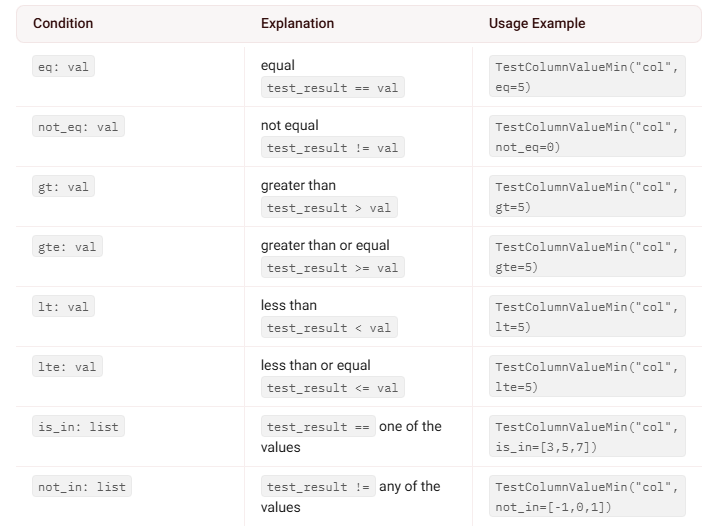

Font: [Documentation](https://docs.evidentlyai.com/user-guide/tests-and-reports/run-tests#id-3.-set-test-conditions)

As with the reports we can see the test information in the jupyter notebook, or export it in different formats.

In [24]:
# Exporting tests to html:

import os
from os import path
from datetime import datetime

# Creating the root folder to store the tests
project_2_artifact_folder = os.path.join("artifacts", 'project_2_tests')
os.makedirs(project_2_artifact_folder, exist_ok= True)

# Generate timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Saving the tests
test_suite_path = os.path.join(project_2_artifact_folder, f'{timestamp} - test_suite.html')

# Saving tests
test_suite.save_html(test_suite_path)

### Using Tests Conditions to Trigger Actions

We can use test results to trigger actions. To do so, we can convert the test suite object into a dictionary and then acess its properties as shown bellow:

In [25]:
# Converting to dictionary
test_suite_dict = test_suite.as_dict()

In [39]:
# Acessing the Whole Dictonary
test_suite_dict

{'tests': [{'name': 'Number of Constant Columns',
   'description': 'The number of constant columns is 0. The test threshold is lte=0.',
   'status': 'SUCCESS',
   'group': 'data_integrity',
   'parameters': {'condition': {'lte': 0}, 'value': 0.0}},
  {'name': 'Max Value',
   'description': 'The maximum value of the column **BILL_AMT1** is 964511.0. The test threshold is lte=7.47e+05.',
   'status': 'FAIL',
   'group': 'data_quality',
   'parameters': {'condition': {'lte': np.float64(746814.0)},
    'value': np.float64(964511.0)}},
  {'name': 'Number of Rows',
   'description': 'The number of rows is 6000. The test threshold is eq=2.4e+04 ± 2.4e+03.',
   'status': 'FAIL',
   'group': 'data_integrity',
   'parameters': {'condition': {'eq': {'value': 24000,
      'relative': 0.1,
      'absolute': 1e-12}},
    'value': 6000.0}},
  {'name': 'Number of Columns',
   'description': 'The number of columns is 25. The test threshold is eq=25.',
   'status': 'SUCCESS',
   'group': 'data_integrit

By using this dictionary we can trigger activity such as the example



In [33]:
# Example of how access properties
test = test_suite_dict['tests'][1]['name']
                            #index of test, #property
result = test_suite_dict['tests'][1]['status']
print(f"test: {test}\nresult: {result}")


test: Max Value
result: FAIL


In [38]:
# Getting each test index to help us in navegating:
for index, test in enumerate (test_suite_dict["tests"]):
    name = test_suite_dict['tests'][index]['name']
    print(f"INDEX: {index} | name: {name}")

INDEX: 0 | name: Number of Constant Columns
INDEX: 1 | name: Max Value
INDEX: 2 | name: Number of Rows
INDEX: 3 | name: Number of Columns
INDEX: 4 | name: Column Types
INDEX: 5 | name: The Share of Missing Values in a Column
INDEX: 6 | name: The Share of Missing Values in a Column
INDEX: 7 | name: The Share of Missing Values in a Column
INDEX: 8 | name: The Share of Missing Values in a Column
INDEX: 9 | name: The Share of Missing Values in a Column
INDEX: 10 | name: The Share of Missing Values in a Column
INDEX: 11 | name: The Share of Missing Values in a Column
INDEX: 12 | name: The Share of Missing Values in a Column
INDEX: 13 | name: The Share of Missing Values in a Column
INDEX: 14 | name: The Share of Missing Values in a Column
INDEX: 15 | name: The Share of Missing Values in a Column
INDEX: 16 | name: The Share of Missing Values in a Column
INDEX: 17 | name: The Share of Missing Values in a Column
INDEX: 18 | name: The Share of Missing Values in a Column
INDEX: 19 | name: The Sha

In [43]:
# Example of how trigger actions, based on specific tests:

## Getting the required variables
max_value_test_name = test_suite_dict['tests'][1]['name']
max_value_test_result = test_suite_dict['tests'][1]['status']

number_of_columns_name = test_suite_dict['tests'][2]['name']
number_of_columns_result = test_suite_dict['tests'][2]['status']

share_of_drifted_columns_name = test_suite_dict['tests'][77]['name']
share_of_drifted_columns_result = test_suite_dict['tests'][77]['status']

## Triggers:
print(f"{'*'*10}Evaluating the {max_value_test_name} Test...{'*'*10}")
if max_value_test_result == "FAIL":
    print(f"Sending E-mail to Data Scientist, we must review the data inputs, or change our input constraints to the user.")

print(f"{'*'*10}Evaluating the {number_of_columns_name} Test...{'*'*10}")
if number_of_columns_result == "FAIL":
    print(f"Sending E-mail to Data Scientist, the user is input data with different columns name")

print(f"{'*'*10}Evaluating the {share_of_drifted_columns_name} Test...{'*'*10}")
if share_of_drifted_columns_result == "FAIL":
    print(f"Sending E-mail to Data Scientist, Model can be suffering of degradation. Evaluate carefully this sutiation.")
    print(f"or...")
    print(f"Triggering automatic retraining in new data...")
else:
    print(f"No data Drift Detected")

**********Evaluating the Max Value Test...**********
Sending E-mail to Data Scientist, we must review the data inputs, or change our input constraints to the user.
**********Evaluating the Number of Rows Test...**********
Sending E-mail to Data Scientist, the user is input data with different columns name
**********Evaluating the Share of Drifted Columns Test...**********
No data Drift Detected


Of course, you must change the actions according to your use case. This was a way to demonstrate how you can trigger generic actions according to your test results.

We can also trigger actions according to the summary of our tests

In [46]:
failed_tests = test_suite_dict['summary']['failed_tests']

if failed_tests > 0:
    print(f"{failed_tests} tests failed...")
    print(f"Sending e-mail to the datascientist with the test report attached.")

else:
    print(f"No failed_tests detected")


13 tests failed...
Sending e-mail to the datascientist with the test report attached.


# RealLife WorkFlow Explanation

Now we can use the knowledge we gathered in order to implement a workflow, because of privacy concerns, I just designed the solution but we are not going to code step by step. However you can easily implement it, by using what is docummented in this notebook. 

**Workflow:**

<iframe style="border: 1px solid rgba(0, 0, 0, 0.1);" width="800" height="450" src="https://embed.figma.com/board/hs1YcFYR0QAi1fEmtKIOyM/evidently?embed-host=share" allowfullscreen></iframe>

Notes: 

* The prediction, prediction logging and e-mail communication are already implemented in another project of mine [here](https://github.com/AlisonZa/ci-cd-machine-learning)

* The Reports and Tests are already explained in this notebook

* To implement the solution you just need to create the file that runs the query on the logger database for production requests